In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import plotly.express as px
import plotly.graph_objects as go
import sqlite3


In [3]:
url = "https://api.spacexdata.com/v4/launches"
response = requests.get(url)
launch_data = response.json()
df = pd.json_normalize(launch_data)


In [4]:
df = df[["name", "date_utc", "success", "rocket", "payloads", "launchpad"]]
df.dropna(subset=["success"], inplace=True)
df["date"] = pd.to_datetime(df["date_utc"]).dt.date


In [5]:
# Load related metadata
rockets = pd.json_normalize(requests.get("https://api.spacexdata.com/v4/rockets").json())
payloads = pd.json_normalize(requests.get("https://api.spacexdata.com/v4/payloads").json())
launchpads = pd.json_normalize(requests.get("https://api.spacexdata.com/v4/launchpads").json())

# Merge rocket
df = df.merge(rockets[["id", "name"]], left_on="rocket", right_on="id", how="left")
df.rename(columns={"name_x": "mission_name", "name_y": "rocket_name"}, inplace=True)

# Merge payload
payloads = payloads[["id", "orbit", "mass_kg"]]
df = df.explode("payloads")
df = df.merge(payloads, left_on="payloads", right_on="id", how="left")

# Merge launchpad
df = df.merge(launchpads[["id", "name", "locality", "latitude", "longitude"]],
              left_on="launchpad", right_on="id", how="left")
df.rename(columns={"name": "launch_site"}, inplace=True)


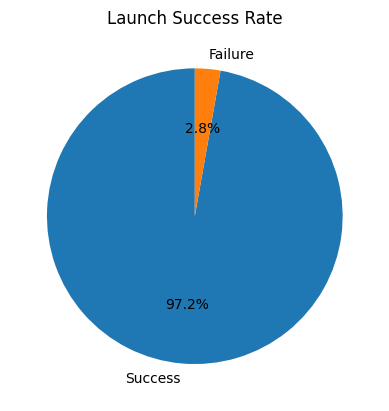

In [6]:
success_counts = df['success'].value_counts().rename({True: "Success", False: "Failure"})
success_counts.plot.pie(autopct='%1.1f%%', startangle=90, title="Launch Success Rate", ylabel="")
plt.show()


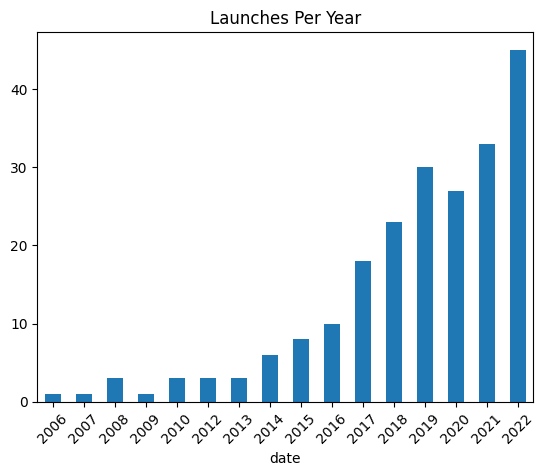

In [7]:
launches_per_year = df.groupby(df['date'].astype(str).str[:4]).size()
launches_per_year.plot(kind='bar', title="Launches Per Year")
plt.xticks(rotation=45)
plt.show()


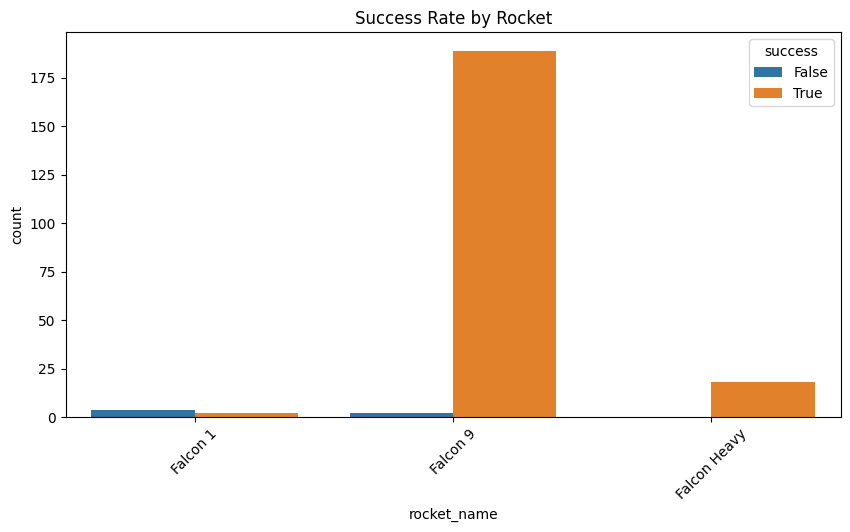

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="rocket_name", hue="success")
plt.xticks(rotation=45)
plt.title("Success Rate by Rocket")
plt.show()


In [9]:
launch_map = folium.Map(location=[28, -80], zoom_start=2)
marker_cluster = MarkerCluster().add_to(launch_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['mission_name']} - {row['date']}\\nSuccess: {row['success']}"
    ).add_to(marker_cluster)

launch_map.save("spacex_launch_map.html")


In [10]:
fig = px.histogram(df, x="orbit", color=df["success"].map({True: "Success", False: "Failure"}),
                   title="Launch Success by Orbit")
fig.show()


In [11]:
conn = sqlite3.connect(":memory:")
df.to_sql("spacex", conn, index=False)

query = """
SELECT launch_site, COUNT(*) as launch_count
FROM spacex
GROUP BY launch_site
ORDER BY launch_count DESC
LIMIT 5
"""

pd.read_sql(query, conn)


,launch_site,launch_count
0,CCSFS SLC 40,106
1,KSC LC 39A,74
2,VAFB SLC 4E,29
3,Kwajalein Atoll,6


In [12]:
model_df = df[["rocket_name", "orbit", "mass_kg", "success"]].dropna()
model_df = pd.get_dummies(model_df, columns=["rocket_name", "orbit"], drop_first=True)

# Convert target to int
model_df["success"] = model_df["success"].astype(int)

X = model_df.drop("success", axis=1)
y = model_df["success"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [13]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9473684210526315
[[ 0  0]
 [ 2 36]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97        38

    accuracy                           0.95        38
   macro avg       0.50      0.47      0.49        38
weighted avg       1.00      0.95      0.97        38



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [14]:
df.to_csv("cleaned_spacex_launch_data.csv", index=False)


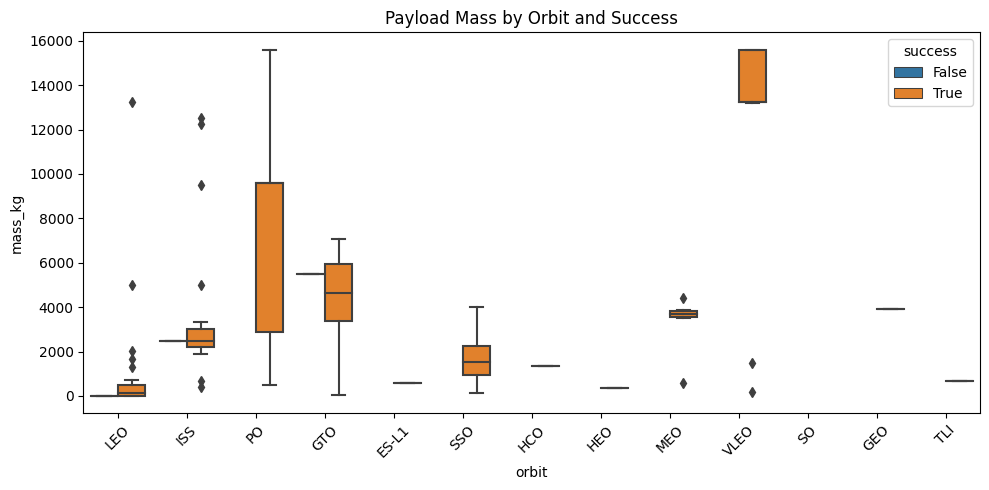

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="orbit", y="mass_kg", hue="success")
plt.title("Payload Mass by Orbit and Success")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


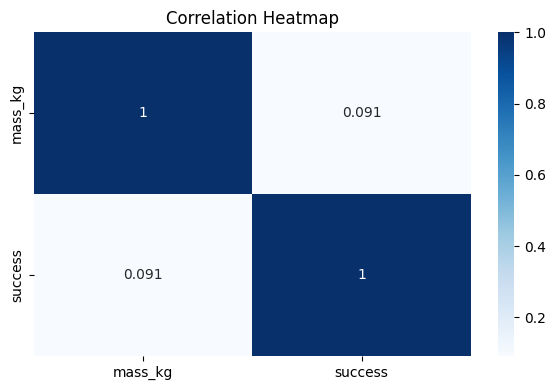

In [24]:
corr = df[["mass_kg", "success"]].dropna().corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [27]:
launch_map = folium.Map(location=[28, -80], zoom_start=2)
marker_cluster = MarkerCluster().add_to(launch_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['mission_name']} - {row['date']}\\nSuccess: {row['success']}"
    ).add_to(marker_cluster)

launch_map.save("spacex_launch_map.html")

# Optional: Save as image using selenium or use a screenshot
# You may manually take a screenshot as `images/folium_launch_map.png`


In [28]:
import plotly.express as px

# Convert success to readable label
df['success_label'] = df['success'].map({True: "Success", False: "Failure"})

# Create the histogram
fig = px.histogram(
    df,
    x="orbit",
    color="success_label",
    barmode="group",
    title="Launch Outcomes by Orbit",
    labels={"orbit": "Orbit Type", "count": "Number of Launches"},
    color_discrete_map={"Success": "green", "Failure": "red"}
)

# Optional: Adjust layout
fig.update_layout(
    xaxis_title="Orbit Type",
    yaxis_title="Number of Launches",
    legend_title="Launch Outcome"
)


# Show the plot in notebook
fig.show()


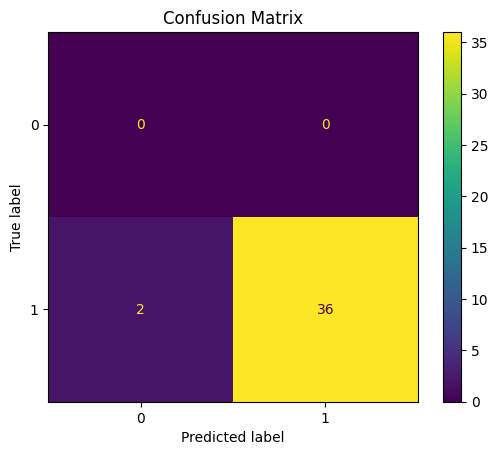

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()


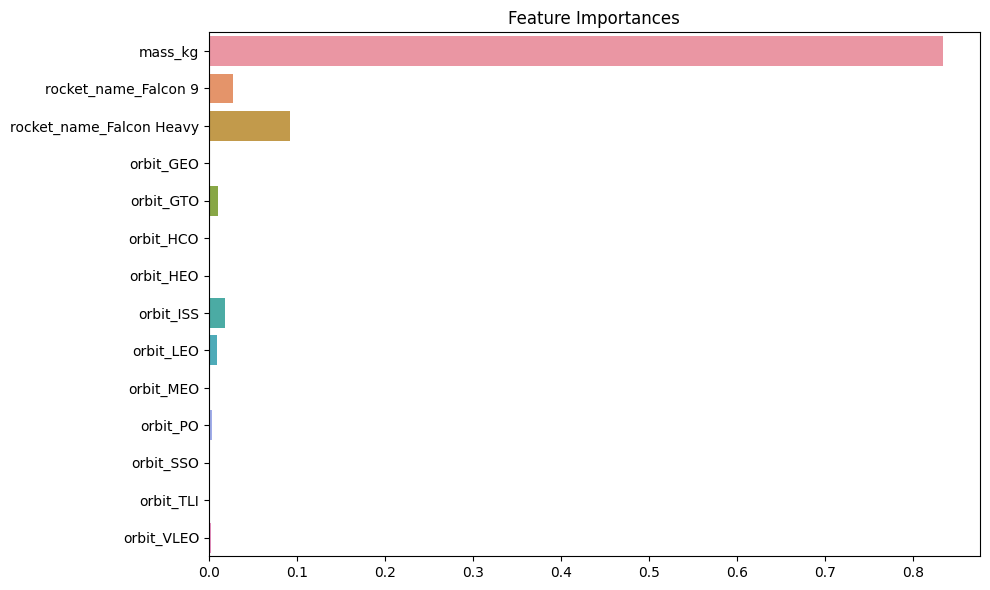

In [32]:
importances = model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()
